<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/4.%20Measurement%20Induced%20Dephasing%20Practice%20duplicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [203]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

In [204]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

# 9. Measurement Induced Noise Dynamical Decoupling

## 1. Two Level System (Rotating Frame)

###1) Hamiltonian & Function Setting

Lab Frame

$H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g\sigma_x(a+a^\dagger)$

$H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{rd} t)}$

$H_2 = B(t) \sigma_x \cos{(\omega_{qd} t)}$

Rotating Frame

$H_0 = -\frac{\omega_q-\omega_{qd}}{2}\sigma_z + ({\omega_r-\omega_{rd}})a^\dagger a + \chi\sigma_z(a^\dagger a)$

$H_1 = \frac{A(t)}{2} (\hat{a} + \hat{a}^\dagger) $

$H_2 = \frac{B(t)}{2}  \sigma_x $

In [285]:
# operator
N = 100

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

In [286]:
sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

In [287]:
sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [288]:
H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())

H1 = 0.5*tensor(qeye(2), a + a.dag())

H2_x = 0.5*sx_composite

In [289]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

In [290]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [291]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [292]:
# time-dependent envelope for qubit drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hqd_rotating_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N_seq']
    Env = args['Env']
    Func = args['Func']

    B = args['B']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': B}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': B}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': B}, T_end)

    return pulse

In [293]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

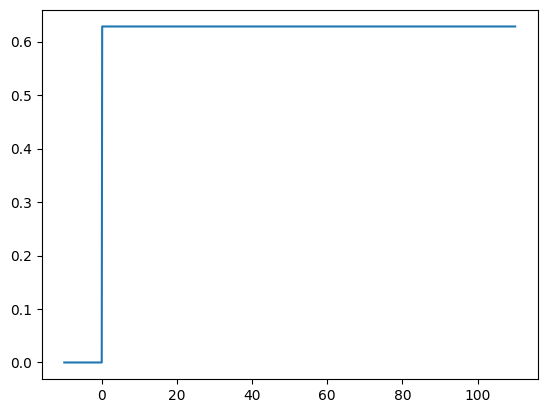

In [294]:
# resonator pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*0.1, 'T': 150}))

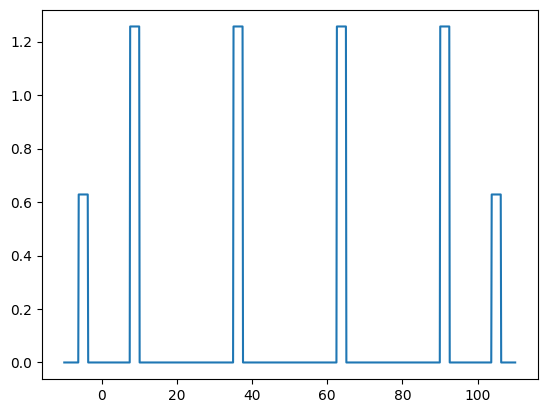

In [295]:
# qubit pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hqd_rotating_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt': -5, 'T_end': 105, 'N_seq': 4, 'Env': 0, 'Func': 0}))

### 2) Test Simulation (Ramsey, Rotating Frame) to Determine Resonator Dimension N

Driving Amplitude $A=0.1, 0.03, 0.01, 0.001GHz$

Resonator Dimension $N=40, 60$

Resonator Readout Frequency $\omega_{rd}=6.90GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Result : Resonator Dimension is set to be N=30. Resonator Drive Freq is set to be 6.9GHz.


In [299]:
A_list = [2*np.pi*0.1, 2*np.pi*0.03, 2*np.pi*0.01, 2*np.pi*0.001]

#### N=40

In [324]:
N = 40

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [325]:
results = []

for k in range(4):

  # Simulation
  tlist = np.linspace(0, 1000, 10000)

  result = mesolve(
    [H0, [H1, Hrd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0, 'T_srt': 0, 'T_end': 1000, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': A_list[k], 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  results.append(result)

KeyboardInterrupt: 

In [ ]:
# Plot sqrt(X**2+Y**2)

for i in range(4):
  plt.plot(tlist, np.sqrt((results[i].expect[0])**2 + (results[i].expect[1])**2), label = '{0}'.format(A_list[i]))

plt.legend(loc = 0)
plt.ylim(0.9,1.1)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation Value')

In [ ]:
# Plot Z

fig, ax = plt.subplots(1, 1)
for i in range(4):
  ax.plot(tlist, results[i].expect[2], label = '{0}'.format(A_list[i]))
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
for i in range(4):
  plt.plot(results[i].expect[3].real, results[i].expect[3].imag, '.-', label = '{0}'.format(A_list[i]))
plt.xlabel(r'Re[$\alpha$]')
plt.ylabel(r'Im[$\alpha$]')
plt.axvline(0.0, color='black', ls='--')
plt.axhline(0.0, color='black', ls='--')
plt.legend()
plt.axis('equal')

In [ ]:
for i in range(4):
  alpha_real = results[i].expect[3].real
  alpha_imag = results[i].expect[3].imag
  print(alpha_real[-1])
  print(alpha_imag[-1])
  print()

In [ ]:
# Plot Resonator Photon Number

fig, ax = plt.subplots(1, 1)
for i in range(4):
  ax.plot(tlist, results[i].expect[4], label = '{0}'.format(A_list[i]))
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

#### N=60

In [257]:
N = 60

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [258]:
results = []

for k in range(4):

  # Simulation
  tlist = np.linspace(0, 1000, 10000)

  result = mesolve(
    [H0, [H1, Hrd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0, 'T_srt': 0, 'T_end': 1000, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': A_list[k], 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  results.append(result)

Text(0, 0.5, 'Expectation Value')

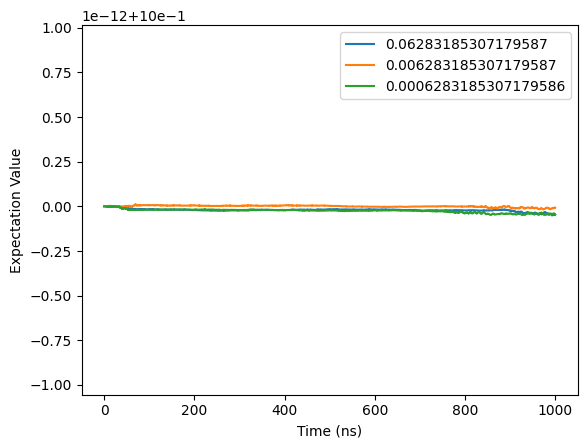

In [259]:
# Plot sqrt(X**2+Y**2)

for i in range(4):
  plt.plot(tlist, np.sqrt((results[i].expect[0])**2 + (results[i].expect[1])**2), label = '{0}'.format(A_list[i]))

plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

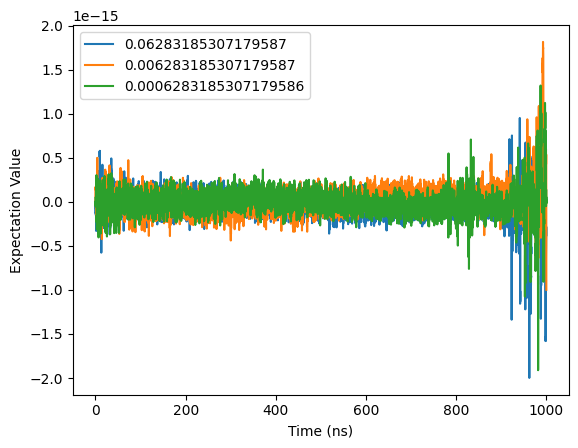

In [260]:
# Plot Z

fig, ax = plt.subplots(1, 1)
for i in range(4):
  ax.plot(tlist, results[i].expect[2], label = '{0}'.format(A_list[i]))
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

(-2.0396370498595537,
 0.09712557380283636,
 -1.1104261234049595,
 0.864936601043371)

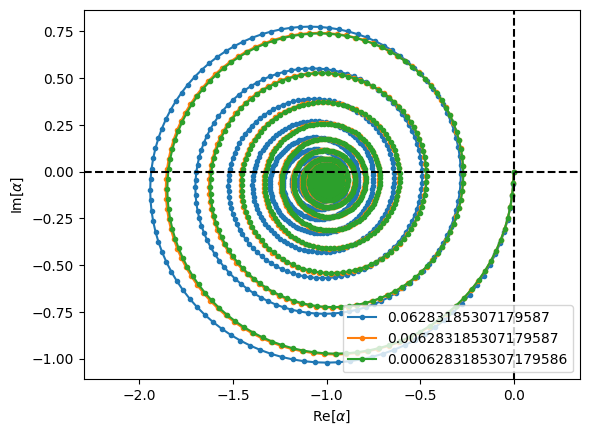

In [261]:
for i in range(4):
  plt.plot(results[i].expect[3].real, results[i].expect[3].imag, '.-', label = '{0}'.format(A_list[i]))
plt.xlabel(r'Re[$\alpha$]')
plt.ylabel(r'Im[$\alpha$]')
plt.axvline(0.0, color='black', ls='--')
plt.axhline(0.0, color='black', ls='--')
plt.legend()
plt.axis('equal')

In [262]:
for i in range(4):
  alpha_real = results[i].expect[3].real
  alpha_imag = results[i].expect[3].imag
  print(alpha_real[-1])
  print(alpha_imag[-1])
  print()

-1.0473815461346319
-0.05236907730672773

-1.0024937655860193
-0.050124688279295455

-0.99800498753113
-0.04990024937654091



Text(0, 0.5, 'Expectation Value')

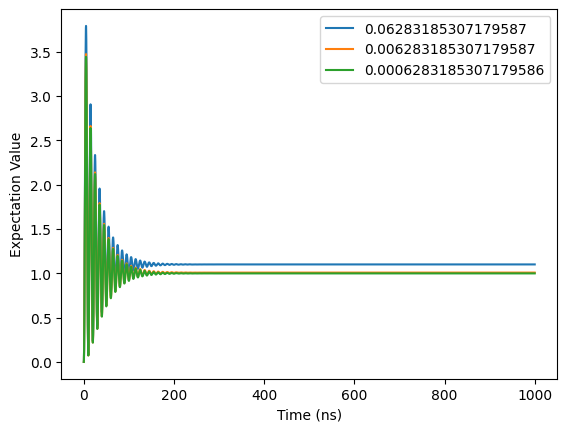

In [263]:
# Plot Resonator Photon Number

fig, ax = plt.subplots(1, 1)
for i in range(4):
  ax.plot(tlist, results[i].expect[4], label = '{0}'.format(A_list[i]))
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 3) Test Simulation (Ramsey, Rotating Frame) to Determine Resonator Dimension N

Driving Amplitude $A=0.01, 0.001, 0.0001GHz$

Resonator Dimension $N=60, 80$

Resonator Readout Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Result : Dimension must be larger than 100. Because of calculation time, 6.99GHz must be rejected.


In [ ]:
A_list = [2*np.pi*0.01, 2*np.pi*0.001, 2*np.pi*0.0001]

#### N=60

In [271]:
N = 60

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [272]:
results = []

for k in range(3):

  # Simulation
  tlist = np.linspace(0, 1000, 10000)

  result = mesolve(
    [H0, [H1, Hrd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0, 'T_srt': 0, 'T_end': 1000, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': A_list[k], 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  results.append(result)

Text(0, 0.5, 'Expectation Value')

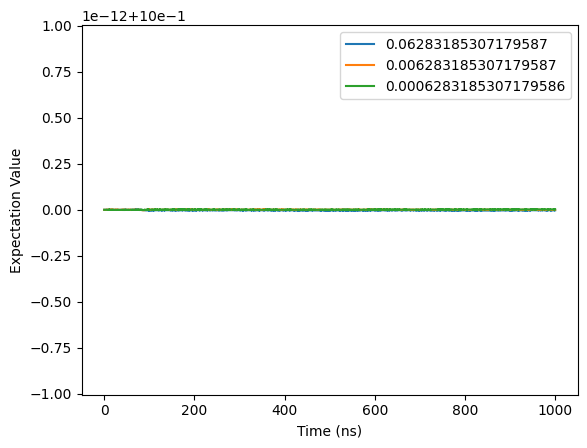

In [273]:
# Plot sqrt(X**2+Y**2)

for i in range(3):
  plt.plot(tlist, np.sqrt((results[i].expect[0])**2 + (results[i].expect[1])**2), label = '{0}'.format(A_list[i]))

plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

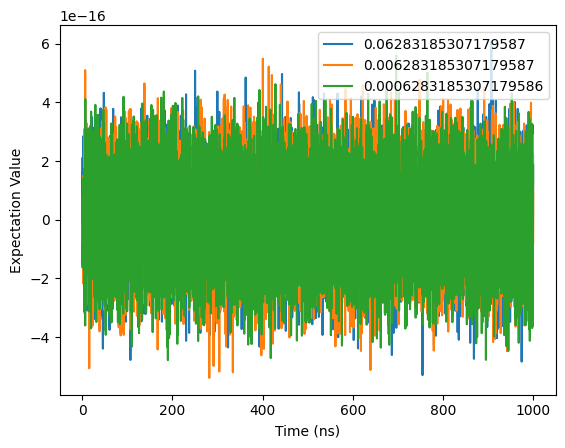

In [274]:
# Plot Z

fig, ax = plt.subplots(1, 1)
for i in range(3):
  ax.plot(tlist, results[i].expect[2], label = '{0}'.format(A_list[i]))
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

(-3.654096311654291, 0.17400458626925197, -6.49596851122576, 3.510067146475302)

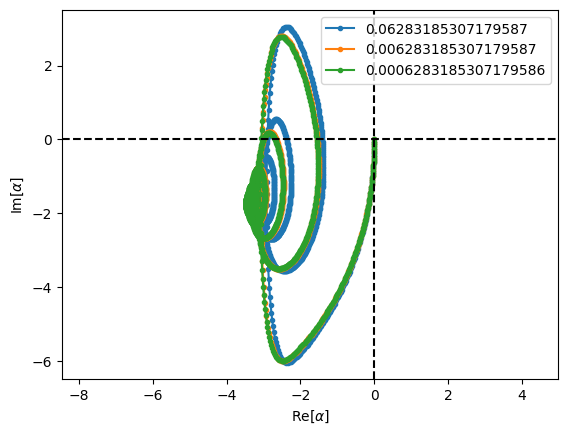

In [275]:
for i in range(3):
  plt.plot(results[i].expect[3].real, results[i].expect[3].imag, '.-', label = '{0}'.format(A_list[i]))
plt.xlabel(r'Re[$\alpha$]')
plt.ylabel(r'Im[$\alpha$]')
plt.axvline(0.0, color='black', ls='--')
plt.axhline(0.0, color='black', ls='--')
plt.legend()
plt.axis('equal')

In [276]:
for i in range(3):
  alpha_real = results[i].expect[3].real
  alpha_imag = results[i].expect[3].imag
  print(alpha_real[-1])
  print(alpha_imag[-1])
  print()

-3.239125757286271
-1.6195629099782958

-3.4488218036093
-1.724410910675846

-3.471688433838202
-1.7358442408867476



Text(0, 0.5, 'Expectation Value')

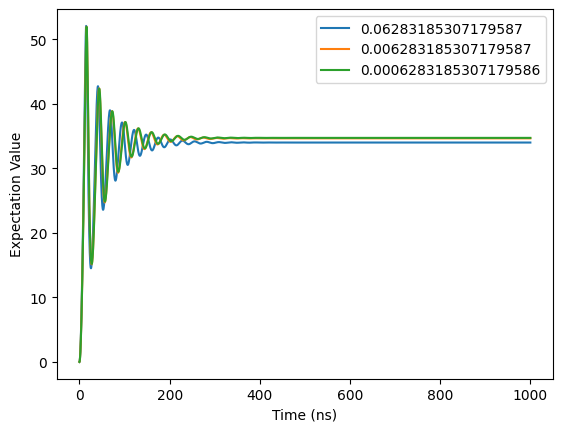

In [277]:
# Plot Resonator Photon Number

fig, ax = plt.subplots(1, 1)
for i in range(3):
  ax.plot(tlist, results[i].expect[4], label = '{0}'.format(A_list[i]))
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

#### N=80

In [278]:
N = 80

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, annihilate_composite, number_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [279]:
results = []

for k in range(3):

  # Simulation
  tlist = np.linspace(0, 1000, 10000)

  result = mesolve(
    [H0, [H1, Hrd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0, 'T_srt': 0, 'T_end': 1000, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': A_list[k], 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  results.append(result)

Text(0, 0.5, 'Expectation Value')

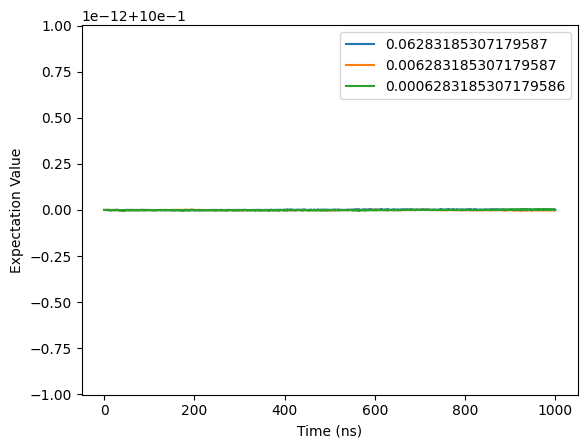

In [280]:
# Plot sqrt(X**2+Y**2)

for i in range(3):
  plt.plot(tlist, np.sqrt((results[i].expect[0])**2 + (results[i].expect[1])**2), label = '{0}'.format(A_list[i]))

plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

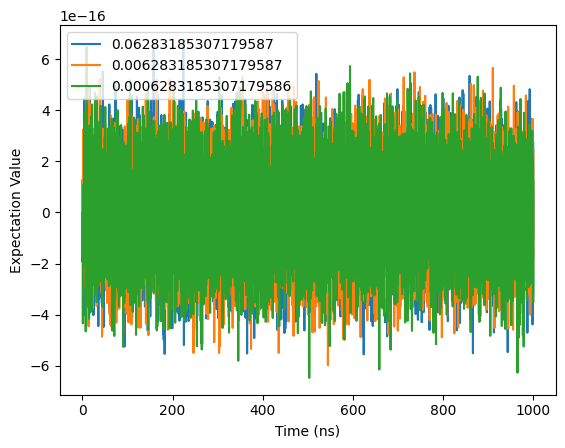

In [281]:
# Plot Z

fig, ax = plt.subplots(1, 1)
for i in range(3):
  ax.plot(tlist, results[i].expect[2], label = '{0}'.format(A_list[i]))
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

(-5.4700013374536525,
 0.2604762541644606,
 -7.367432342160101,
 3.1972342323503278)

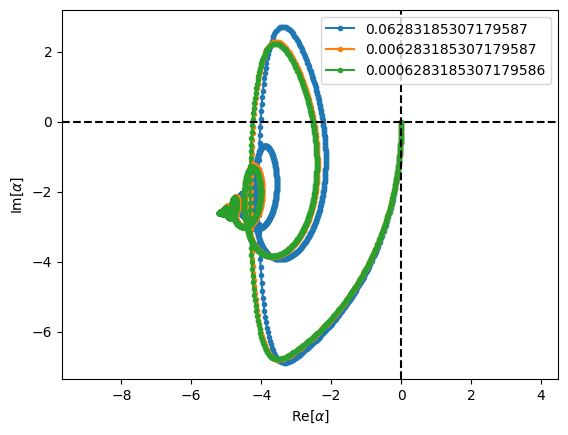

In [282]:
for i in range(3):
  plt.plot(results[i].expect[3].real, results[i].expect[3].imag, '.-', label = '{0}'.format(A_list[i]))
plt.xlabel(r'Re[$\alpha$]')
plt.ylabel(r'Im[$\alpha$]')
plt.axvline(0.0, color='black', ls='--')
plt.axhline(0.0, color='black', ls='--')
plt.legend()
plt.axis('equal')

In [283]:
for i in range(3):
  alpha_real = results[i].expect[3].real
  alpha_imag = results[i].expect[3].imag
  print(alpha_real[-1])
  print(alpha_imag[-1])
  print()

-4.754455171371151
-2.377227587343396

-5.163622609467645
-2.581811306235877

-5.209525083289193
-2.6047625433805908



Text(0, 0.5, 'Expectation Value')

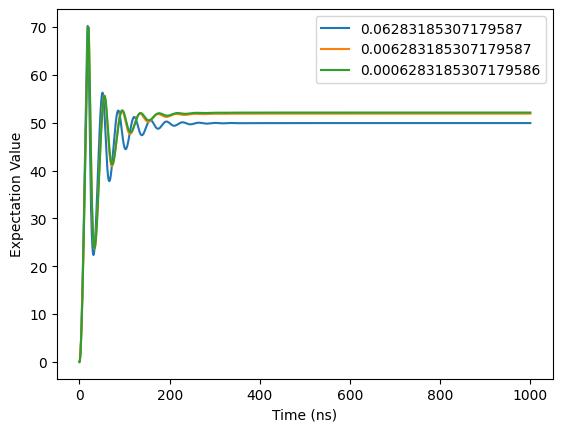

In [284]:
# Plot Resonator Photon Number

fig, ax = plt.subplots(1, 1)
for i in range(3):
  ax.plot(tlist, results[i].expect[4], label = '{0}'.format(A_list[i]))
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 4) Off Diagonal Term Evolution

Resonator Dimension $N=40$

Resonator Readout Frequency $\omega_{rd}=6.90GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Result :


In [330]:
N = 30

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [ ]:
plus_0 = []

for k in range(20):

  # Simulation
  tlist = np.linspace(0, 1000, 10000)

  result = mesolve(
    [H0, [H1, Hrd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.1, 'T_srt': -20, 'T_end': 1020, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.8, 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_0.append(result.expect[0])
  print(k)

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
plus_0_avg = []


for i in range(10000):
  s = 0

  for j in range(20):
    temp = plus_0[j]
    s = s + temp[i]

  s = s / 20
  plus_0_avg.append(s)

plus_0_avg = np.array(plus_0_avg)


plt.plot(tlist, plus_0_avg, label = 'A=0.1GHz, n~3')
plt.legend(loc = 0)
plt.ylim(-1,1)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation Value')

In [ ]:
plus_1 = []

for k in range(20):

  # Simulation
  tlist = np.linspace(0, 1000, 10000)

  result = mesolve(
    [H0, [H1, Hrd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.1, 'T_srt': -20, 'T_end': 1020, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.5, 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_1.append(result.expect[0])
  print(k)

In [ ]:
plus_1_avg = []


for i in range(10000):
  s = 0

  for j in range(20):
    temp = plus_1[j]
    s = s + temp[i]

  s = s / 20
  plus_1_avg.append(s)

plus_1_avg = np.array(plus_1_avg)


plt.plot(tlist, plus_1_avg, label = 'A=0.5GHz, n~6')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation Value')

In [ ]:
plus_2 = []

for k in range(20):

  # Simulation
  tlist = np.linspace(0, 1000, 10000)

  result = mesolve(
    [H0, [H1, Hrd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.1, 'T_srt': -20, 'T_end': 1020, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.2, 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_2.append(result.expect[0])
  print(k)

In [ ]:
plus_2_avg = []


for i in range(10000):
  s = 0

  for j in range(20):
    temp = plus_2[j]
    s = s + temp[i]

  s = s / 20
  plus_2_avg.append(s)

plus_2_avg = np.array(plus_2_avg)


plt.plot(tlist, plus_2_avg, label = 'A=0.2GHz, n~1')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Expectation Value')

### 5) Spectroscopy


In [ ]:
plus_0_avg_fft = np.fft.fftshift(np.fft.fft(plus_0_avg))
plus_0_avg_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_0_avg), d=tlist[1]-tlist[0]))

plus_1_avg_fft = np.fft.fftshift(np.fft.fft(plus_1_avg))
plus_1_avg_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_1_avg), d=tlist[1]-tlist[0]))

plus_2_avg_fft = np.fft.fftshift(np.fft.fft(plus_2_avg))
plus_2_avg_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_2_avg), d=tlist[1]-tlist[0]))

plt.figure()

plt.plot(plus_0_avg_freq, np.abs(plus_0_avg_fft))
plt.plot(plus_1_avg_freq, np.abs(plus_1_avg_fft))
plt.plot(plus_2_avg_freq, np.abs(plus_2_avg_fft))

plt.legend()
plt.xlim(-1.2,-0.05)
plt.ylim(0,0.00000000001)
plt.xlabel('Freq(GHz)')
plt.ylabel('FT Absolute Value (linear scale)')

# 10. Measurement Induced Dephasing Dynamical Decoupling

### 1) Hamiltonian Setting

In [ ]:
# operator
N = 100

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

gamma_1 = 2 * np.pi * 0.0002  # qubit longitudinal relaxation rate
gamma_2 = 2 * np.pi * 0.00015 # qubit transverse relaxation rate

delta = omega_q-omega_rd

In [ ]:
sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

In [ ]:
sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [ ]:
H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite
H2_z = 0.5*sz_composite

### 2) X $\pi$-Pulse derived Measurement Induced Dephasing Decoupling without Qubit Natural Relaxation

Resonator Dimension $100$

$π$-Pulse Number $N = 0, 2, 4, 6, 8, 10, 12, 20$

Driving Amplitude $A=0.0001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Evolution Time 0 ~ 100ns

In [ ]:
T = 100
tlist = np.linspace(0, T, 10000)

result41 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result42 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result43 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result44 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 6, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result45 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 8, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result46 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result47 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 12, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result48 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

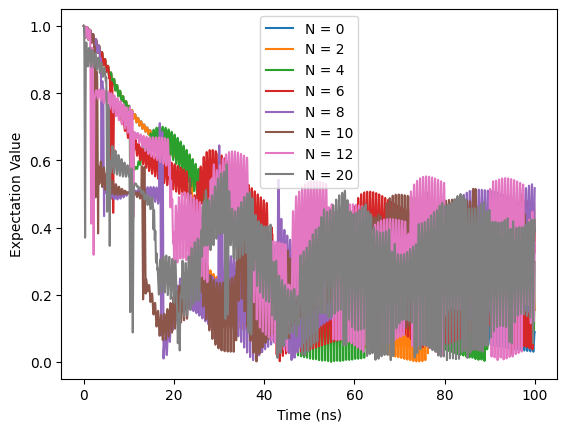

In [ ]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result41.expect[0])**2 + (result41.expect[1])**2), label = 'N = 0')
ax.plot(tlist, np.sqrt((result42.expect[0])**2 + (result42.expect[1])**2), label = 'N = 2')
ax.plot(tlist, np.sqrt((result43.expect[0])**2 + (result43.expect[1])**2), label = 'N = 4')
ax.plot(tlist, np.sqrt((result44.expect[0])**2 + (result44.expect[1])**2), label = 'N = 6')
ax.plot(tlist, np.sqrt((result45.expect[0])**2 + (result45.expect[1])**2), label = 'N = 8')
ax.plot(tlist, np.sqrt((result46.expect[0])**2 + (result46.expect[1])**2), label = 'N = 10')
ax.plot(tlist, np.sqrt((result47.expect[0])**2 + (result47.expect[1])**2), label = 'N = 12')
ax.plot(tlist, np.sqrt((result48.expect[0])**2 + (result48.expect[1])**2), label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

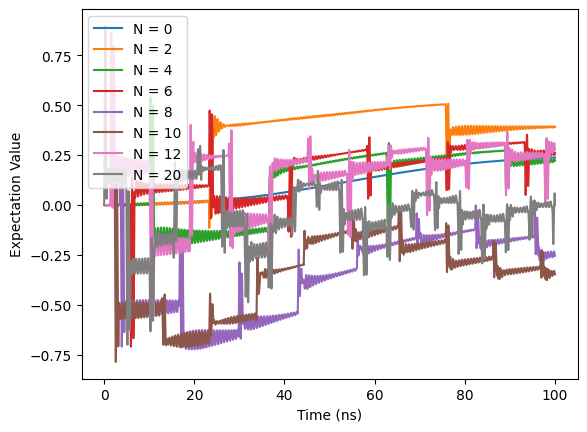

In [ ]:
# Plot Z for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result41.expect[2], label = 'N = 0')
ax.plot(tlist, result42.expect[2], label = 'N = 2')
ax.plot(tlist, result43.expect[2], label = 'N = 4')
ax.plot(tlist, result44.expect[2], label = 'N = 6')
ax.plot(tlist, result45.expect[2], label = 'N = 8')
ax.plot(tlist, result46.expect[2], label = 'N = 10')
ax.plot(tlist, result47.expect[2], label = 'N = 12')
ax.plot(tlist, result48.expect[2], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

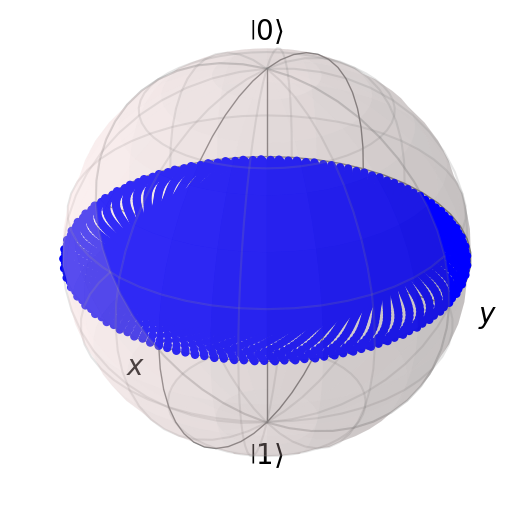

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result41.expect, meth="s")
sphere.show()

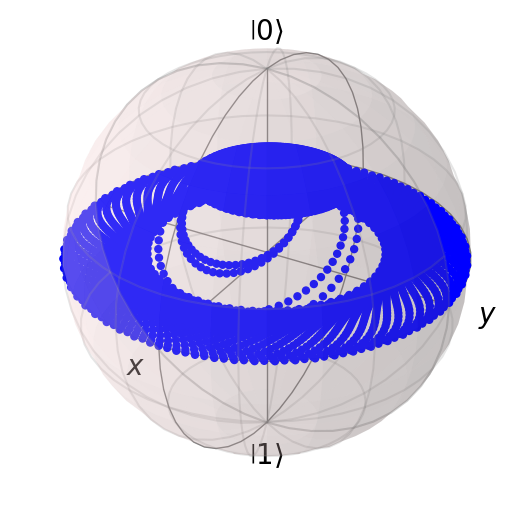

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result42.expect, meth="s")
sphere.show()

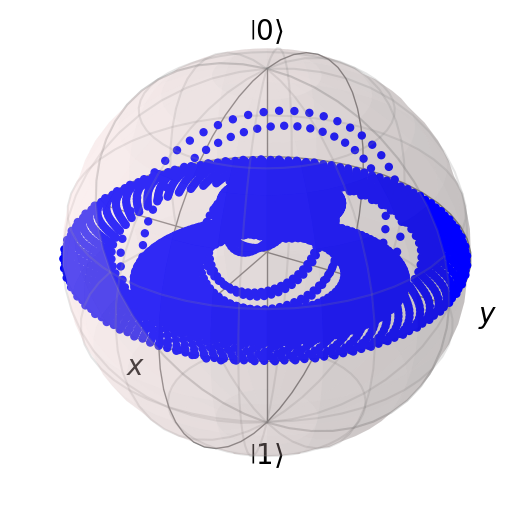

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result43.expect, meth="s")
sphere.show()

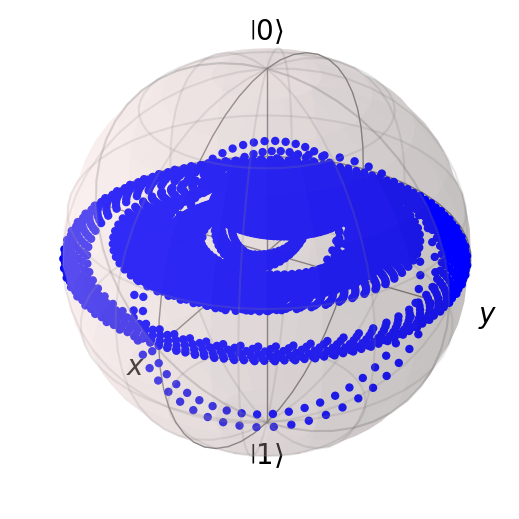

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result44.expect, meth="s")
sphere.show()

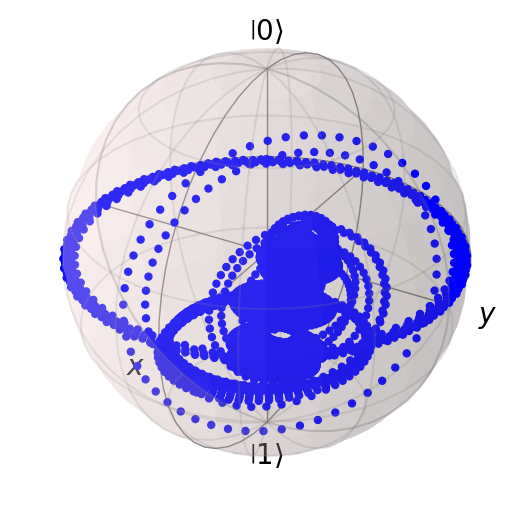

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result45.expect, meth="s")
sphere.show()

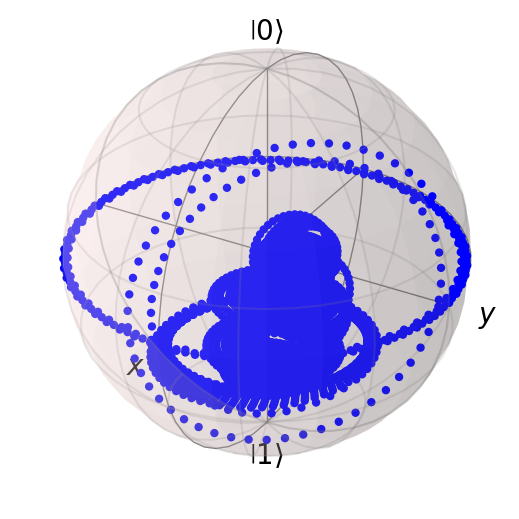

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result46.expect, meth="s")
sphere.show()

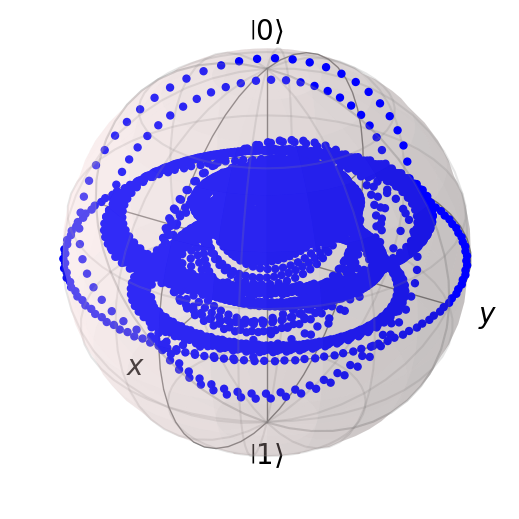

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result47.expect, meth="s")
sphere.show()

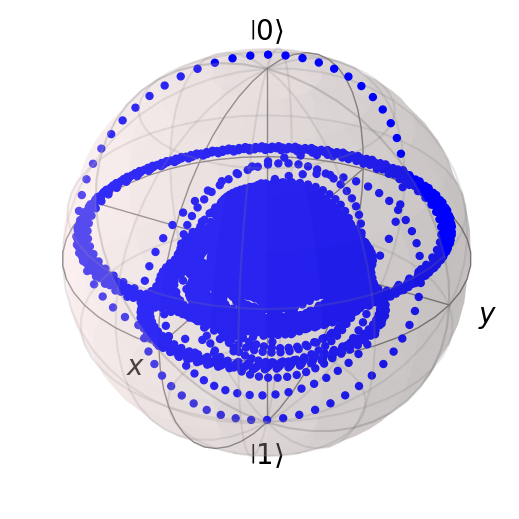

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result48.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

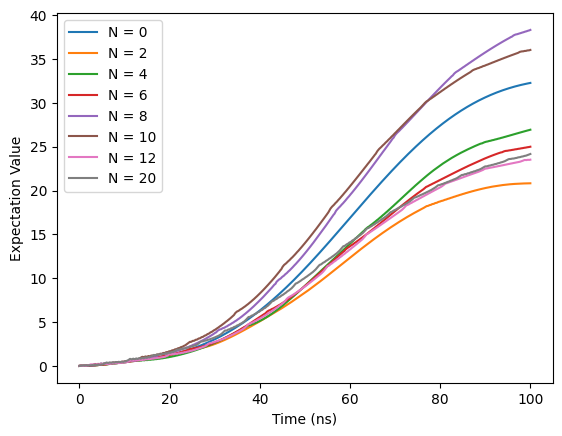

In [ ]:
# Plot photon number for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result41.expect[7], label = 'N = 0')
ax.plot(tlist, result42.expect[7], label = 'N = 2')
ax.plot(tlist, result43.expect[7], label = 'N = 4')
ax.plot(tlist, result44.expect[7], label = 'N = 6')
ax.plot(tlist, result45.expect[7], label = 'N = 8')
ax.plot(tlist, result46.expect[7], label = 'N = 10')
ax.plot(tlist, result47.expect[7], label = 'N = 12')
ax.plot(tlist, result48.expect[7], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 3) X $\pi$-Pulse derived Measurement Induced Dephasing Decoupling without Qubit Natural Relaxation

Different pi-pulse than 2)

Resonator Dimension $100$

$π$-Pulse Number $N = 0, 2, 4, 6, 8, 10, 12, 20$

Driving Amplitude $A=0.0001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Evolution Time 0 ~ 100ns

In [ ]:
T = 100
tlist = np.linspace(0, T, 10000)

result49 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result50 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result51 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result52 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 6, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result53 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 8, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result54 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result55 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 12, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result56 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

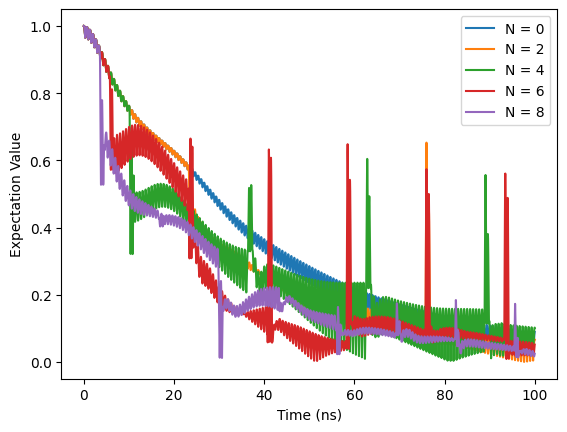

In [ ]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result49.expect[0])**2 + (result49.expect[1])**2), label = 'N = 0')
ax.plot(tlist, np.sqrt((result50.expect[0])**2 + (result50.expect[1])**2), label = 'N = 2')
ax.plot(tlist, np.sqrt((result51.expect[0])**2 + (result51.expect[1])**2), label = 'N = 4')
ax.plot(tlist, np.sqrt((result52.expect[0])**2 + (result52.expect[1])**2), label = 'N = 6')
ax.plot(tlist, np.sqrt((result53.expect[0])**2 + (result53.expect[1])**2), label = 'N = 8')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

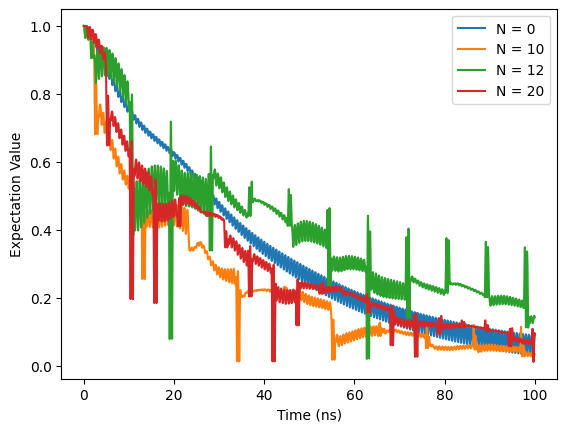

In [ ]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result49.expect[0])**2 + (result49.expect[1])**2), label = 'N = 0')
ax.plot(tlist, np.sqrt((result54.expect[0])**2 + (result54.expect[1])**2), label = 'N = 10')
ax.plot(tlist, np.sqrt((result55.expect[0])**2 + (result55.expect[1])**2), label = 'N = 12')
ax.plot(tlist, np.sqrt((result56.expect[0])**2 + (result56.expect[1])**2), label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

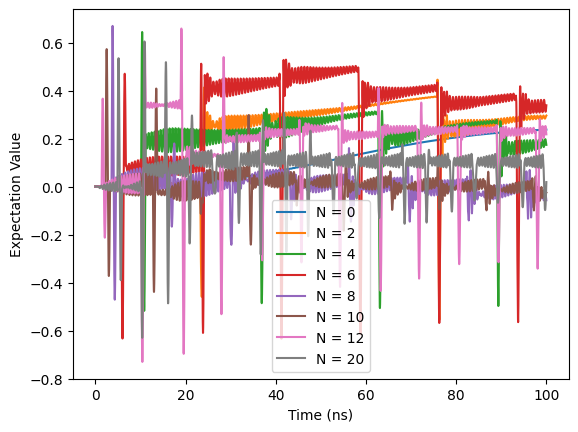

In [ ]:
# Plot Z for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result49.expect[2], label = 'N = 0')
ax.plot(tlist, result50.expect[2], label = 'N = 2')
ax.plot(tlist, result51.expect[2], label = 'N = 4')
ax.plot(tlist, result52.expect[2], label = 'N = 6')
ax.plot(tlist, result53.expect[2], label = 'N = 8')
ax.plot(tlist, result54.expect[2], label = 'N = 10')
ax.plot(tlist, result55.expect[2], label = 'N = 12')
ax.plot(tlist, result56.expect[2], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

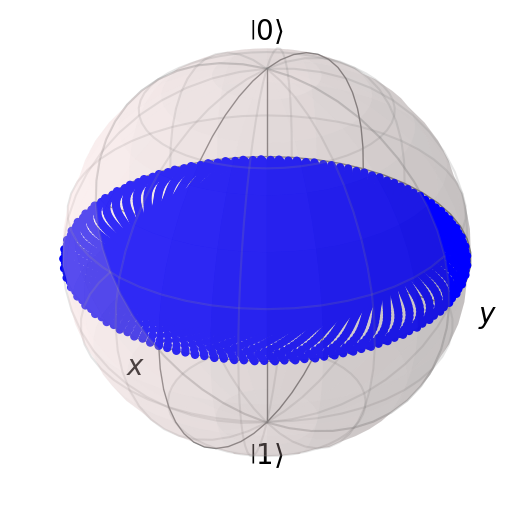

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result49.expect, meth="s")
sphere.show()

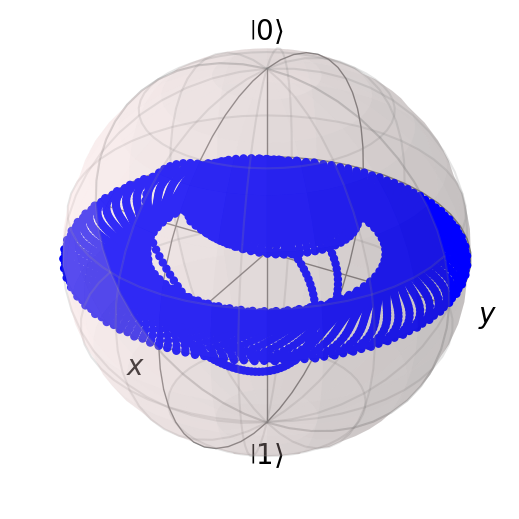

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result50.expect, meth="s")
sphere.show()

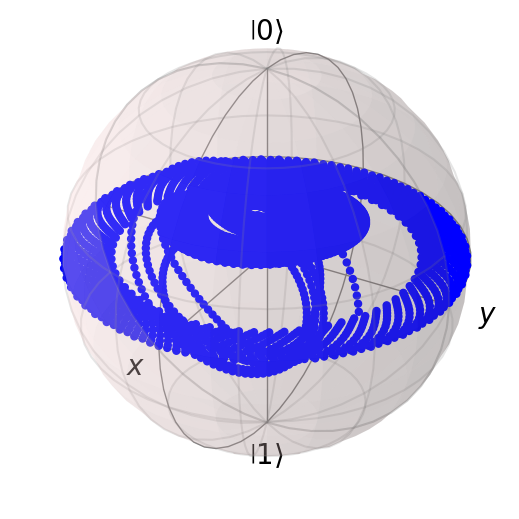

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result51.expect, meth="s")
sphere.show()

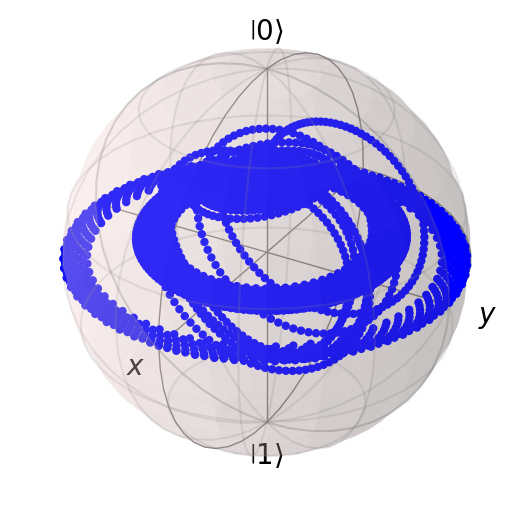

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result52.expect, meth="s")
sphere.show()

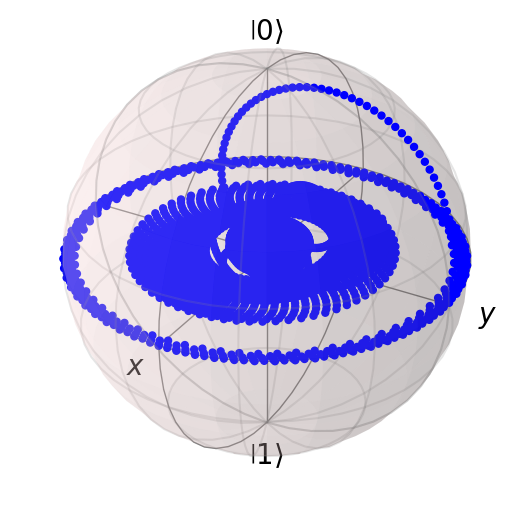

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result53.expect, meth="s")
sphere.show()

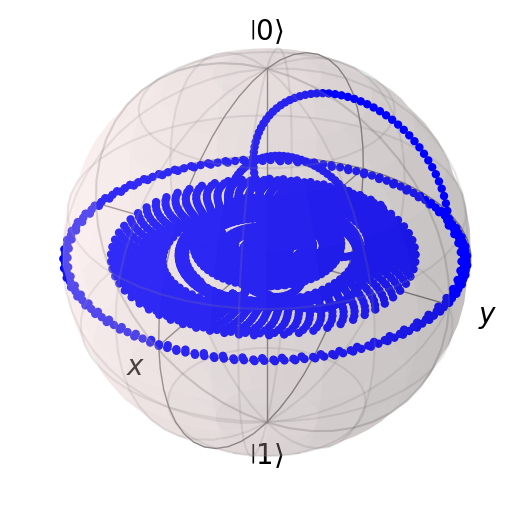

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result54.expect, meth="s")
sphere.show()

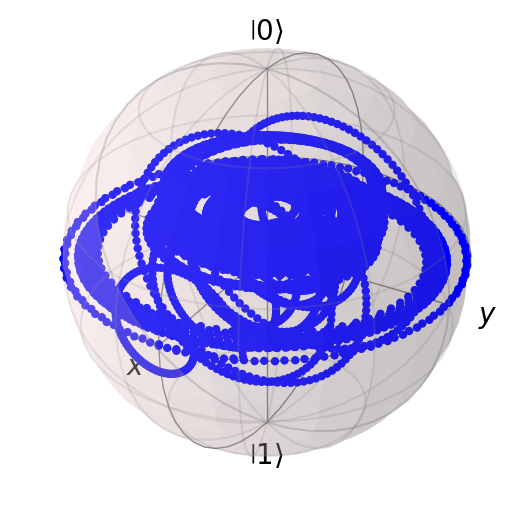

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result55.expect, meth="s")
sphere.show()

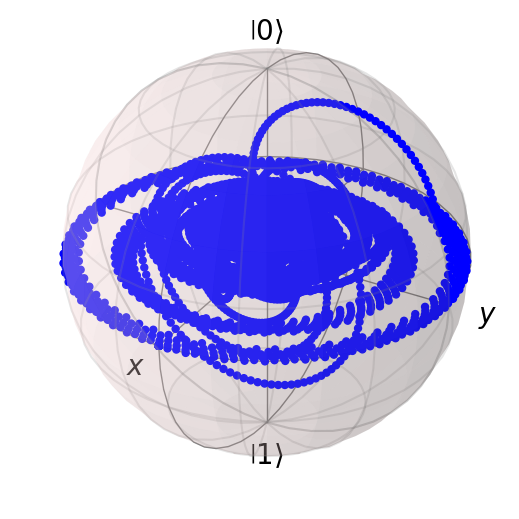

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result56.expect, meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

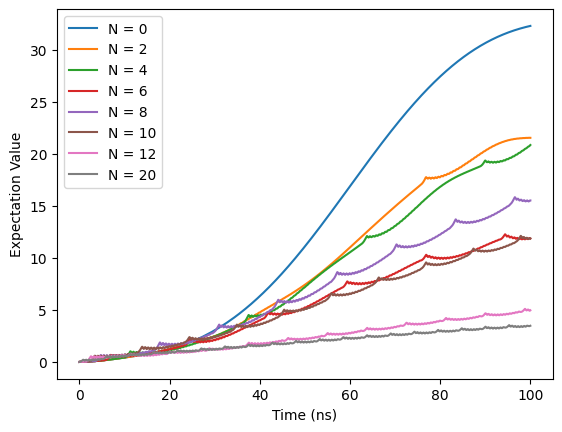

In [ ]:
# Plot photon number for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result49.expect[7], label = 'N = 0')
ax.plot(tlist, result50.expect[7], label = 'N = 2')
ax.plot(tlist, result51.expect[7], label = 'N = 4')
ax.plot(tlist, result52.expect[7], label = 'N = 6')
ax.plot(tlist, result53.expect[7], label = 'N = 8')
ax.plot(tlist, result54.expect[7], label = 'N = 10')
ax.plot(tlist, result55.expect[7], label = 'N = 12')
ax.plot(tlist, result56.expect[7], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 4) X $\pi$-Pulse derived Measurement Induced Dephasing Decoupling without Qubit Natural Relaxation

Resonator Dimension $100$

$π$-Pulse Number $N = 0, 2, 4, 6, 8, 10, 12, 20$

Driving Amplitude $A=0.0001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Coupling Constant $g=0.01GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Evolution Time 0 ~ 100ns

In [ ]:
# operator
N = 100

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz

g = 2 * np.pi * 0.01           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

gamma_1 = 2 * np.pi * 0.0002  # qubit longitudinal relaxation rate
gamma_2 = 2 * np.pi * 0.00015 # qubit transverse relaxation rate

delta = omega_q-omega_rd

sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite
H2_z = 0.5*sz_composite

In [ ]:
T = 100
tlist = np.linspace(0, T, 10000)

result57 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result58 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result59 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result60 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 6, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result61 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 8, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result62 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result63 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 12, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result64 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

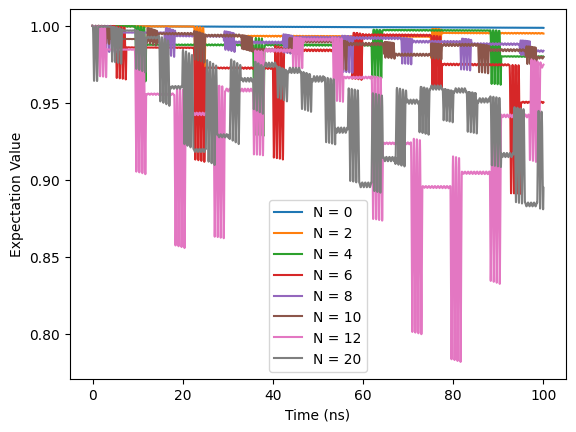

In [ ]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result57.expect[0])**2 + (result57.expect[1])**2), label = 'N = 0')
ax.plot(tlist, np.sqrt((result58.expect[0])**2 + (result58.expect[1])**2), label = 'N = 2')
ax.plot(tlist, np.sqrt((result59.expect[0])**2 + (result59.expect[1])**2), label = 'N = 4')
ax.plot(tlist, np.sqrt((result60.expect[0])**2 + (result60.expect[1])**2), label = 'N = 6')
ax.plot(tlist, np.sqrt((result61.expect[0])**2 + (result61.expect[1])**2), label = 'N = 8')
ax.plot(tlist, np.sqrt((result62.expect[0])**2 + (result62.expect[1])**2), label = 'N = 10')
ax.plot(tlist, np.sqrt((result63.expect[0])**2 + (result63.expect[1])**2), label = 'N = 12')
ax.plot(tlist, np.sqrt((result64.expect[0])**2 + (result64.expect[1])**2), label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

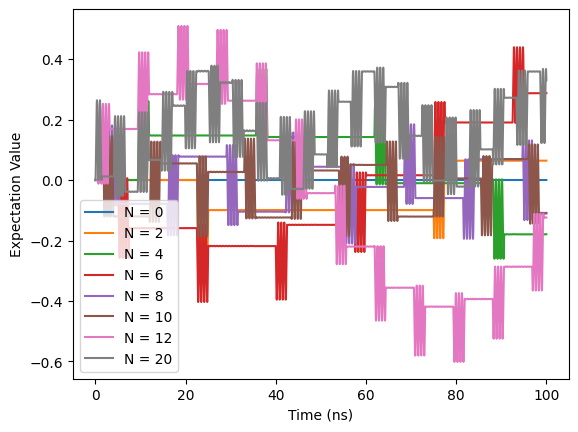

In [ ]:
# Plot Z for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result57.expect[2], label = 'N = 0')
ax.plot(tlist, result58.expect[2], label = 'N = 2')
ax.plot(tlist, result59.expect[2], label = 'N = 4')
ax.plot(tlist, result60.expect[2], label = 'N = 6')
ax.plot(tlist, result61.expect[2], label = 'N = 8')
ax.plot(tlist, result62.expect[2], label = 'N = 10')
ax.plot(tlist, result63.expect[2], label = 'N = 12')
ax.plot(tlist, result64.expect[2], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

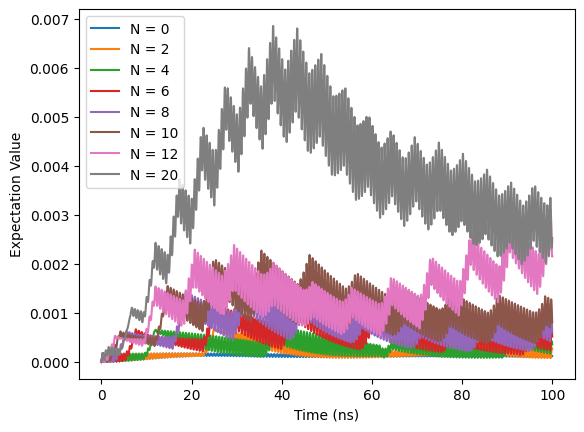

In [ ]:
# Plot photon number for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result57.expect[7], label = 'N = 0')
ax.plot(tlist, result58.expect[7], label = 'N = 2')
ax.plot(tlist, result59.expect[7], label = 'N = 4')
ax.plot(tlist, result60.expect[7], label = 'N = 6')
ax.plot(tlist, result61.expect[7], label = 'N = 8')
ax.plot(tlist, result62.expect[7], label = 'N = 10')
ax.plot(tlist, result63.expect[7], label = 'N = 12')
ax.plot(tlist, result64.expect[7], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

### 5) X $\pi$-Pulse derived Measurement Induced Dephasing Decoupling without Qubit Natural Relaxation

Different pi-pulse than 4)

Resonator Dimension $100$

$π$-Pulse Number $N = 0, 2, 4, 6, 8, 10, 12, 20$

Driving Amplitude $A=0.0001GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Coupling Constant $g=0.01GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Evolution Time 0 ~ 100ns

In [ ]:
T = 100
tlist = np.linspace(0, T, 10000)

result65 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result66 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 2, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result67 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 4, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result68 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 6, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result69 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 8, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result70 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 10, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result71 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 12, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result72 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x], [H2_z, Hrd_qubit_rotating_frame_z]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*1, 'B': delta, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': T+2.5, 'N': 20, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.0001, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

KeyboardInterrupt: 

In [ ]:
# Plot sqrt(X**2+Y**2) for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, np.sqrt((result65.expect[0])**2 + (result65.expect[1])**2), label = 'N = 0')
ax.plot(tlist, np.sqrt((result66.expect[0])**2 + (result66.expect[1])**2), label = 'N = 2')
ax.plot(tlist, np.sqrt((result67.expect[0])**2 + (result67.expect[1])**2), label = 'N = 4')
ax.plot(tlist, np.sqrt((result68.expect[0])**2 + (result68.expect[1])**2), label = 'N = 6')
ax.plot(tlist, np.sqrt((result69.expect[0])**2 + (result69.expect[1])**2), label = 'N = 8')
ax.plot(tlist, np.sqrt((result70.expect[0])**2 + (result70.expect[1])**2), label = 'N = 10')
ax.plot(tlist, np.sqrt((result71.expect[0])**2 + (result71.expect[1])**2), label = 'N = 12')
ax.plot(tlist, np.sqrt((result72.expect[0])**2 + (result72.expect[1])**2), label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
# Plot Z for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result65.expect[2], label = 'N = 0')
ax.plot(tlist, result66.expect[2], label = 'N = 2')
ax.plot(tlist, result67.expect[2], label = 'N = 4')
ax.plot(tlist, result68.expect[2], label = 'N = 6')
ax.plot(tlist, result69.expect[2], label = 'N = 8')
ax.plot(tlist, result70.expect[2], label = 'N = 10')
ax.plot(tlist, result71.expect[2], label = 'N = 12')
ax.plot(tlist, result72.expect[2], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
# Plot photon number for various pi-Pulse Shot Number N : 0, 2, 4, 6, 8, 10, 12, 20

fig, ax = plt.subplots(1, 1)

ax.plot(tlist, result65.expect[7], label = 'N = 0')
ax.plot(tlist, result66.expect[7], label = 'N = 2')
ax.plot(tlist, result67.expect[7], label = 'N = 4')
ax.plot(tlist, result68.expect[7], label = 'N = 6')
ax.plot(tlist, result69.expect[7], label = 'N = 8')
ax.plot(tlist, result70.expect[7], label = 'N = 10')
ax.plot(tlist, result71.expect[7], label = 'N = 12')
ax.plot(tlist, result72.expect[7], label = 'N = 20')

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')